<a href="https://colab.research.google.com/github/ashwin642/news_classifier/blob/main/fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded successfully from fake_or_real_news.csv (encoding: utf-8)
Dataset shape: (6335, 4)
Columns: ['Unnamed: 0', 'title', 'text', 'label']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None

Missing values:
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

First 5 rows:
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in 

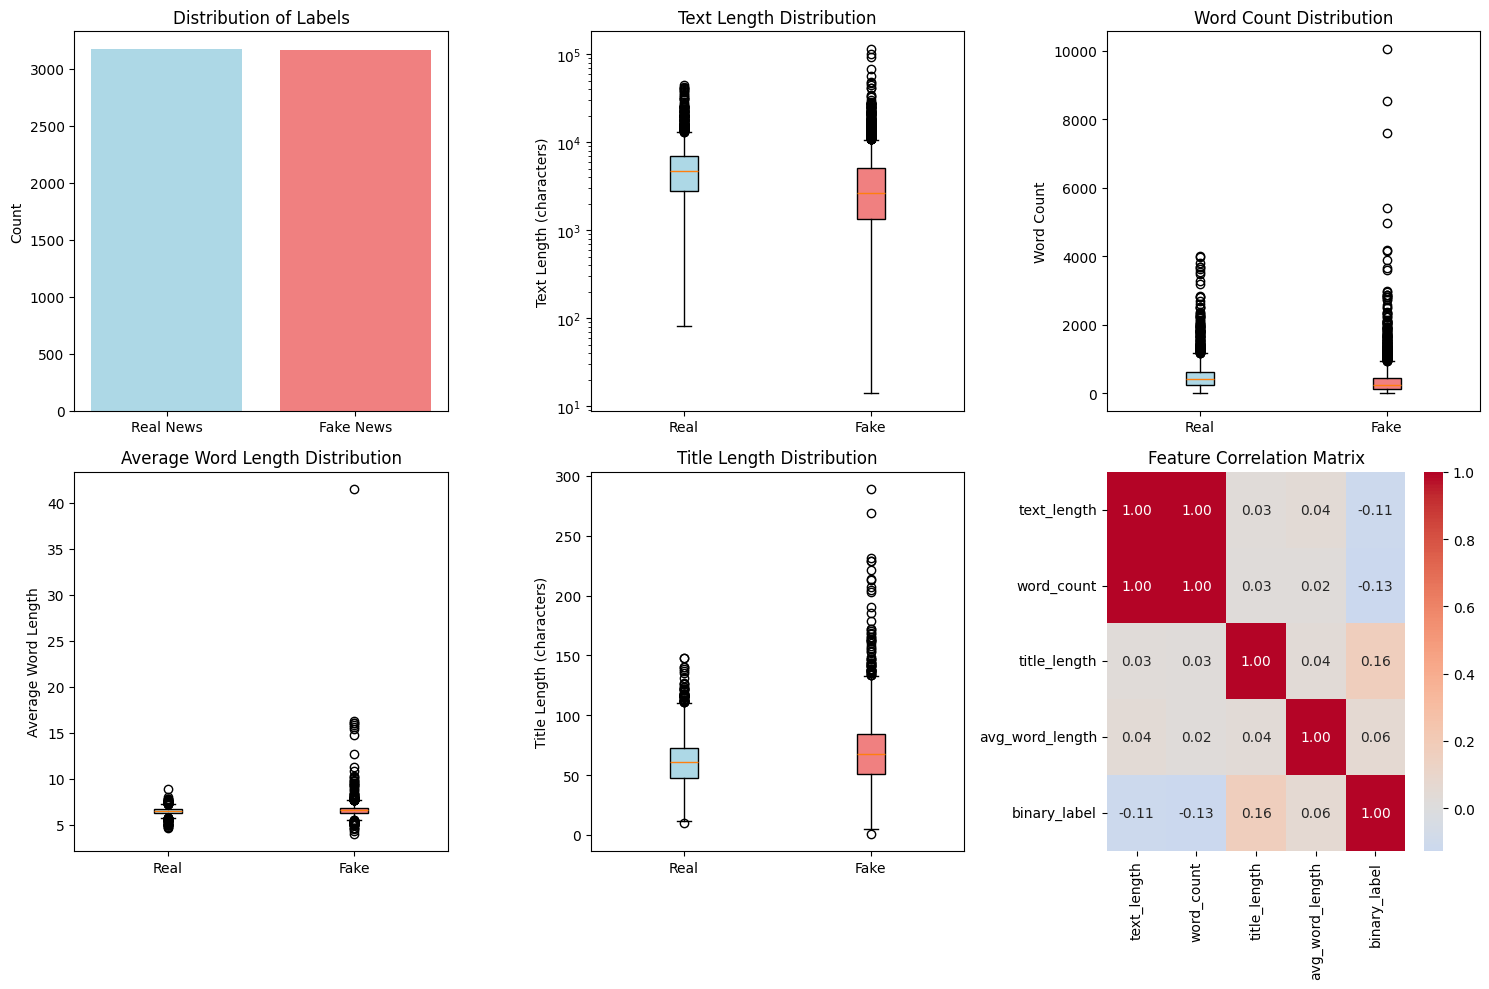


Dataset Statistics:
Total articles: 6335
Fake news articles: 3164
Real news articles: 3171
Average text length: 4774 characters
Average word count: 432 words

STATISTICAL COMPARISON: REAL vs FAKE NEWS

Real News Statistics:
        text_length   word_count  title_length  avg_word_length
count   3171.000000  3171.000000   3171.000000      3171.000000
mean    5354.543362   489.798802     61.383160         6.502011
std     4351.165281   395.938702     19.056875         0.327400
min       81.000000     7.000000     10.000000         4.666667
25%     2793.500000   256.500000     48.000000         6.308966
50%     4745.000000   429.000000     61.000000         6.500000
75%     6895.000000   628.500000     73.000000         6.690797
max    44164.000000  4000.000000    148.000000         8.857143

Fake News Statistics:
         text_length    word_count  title_length  avg_word_length
count    3164.000000   3164.000000   3164.000000      3164.000000
mean     4191.227244    374.560051     69.18

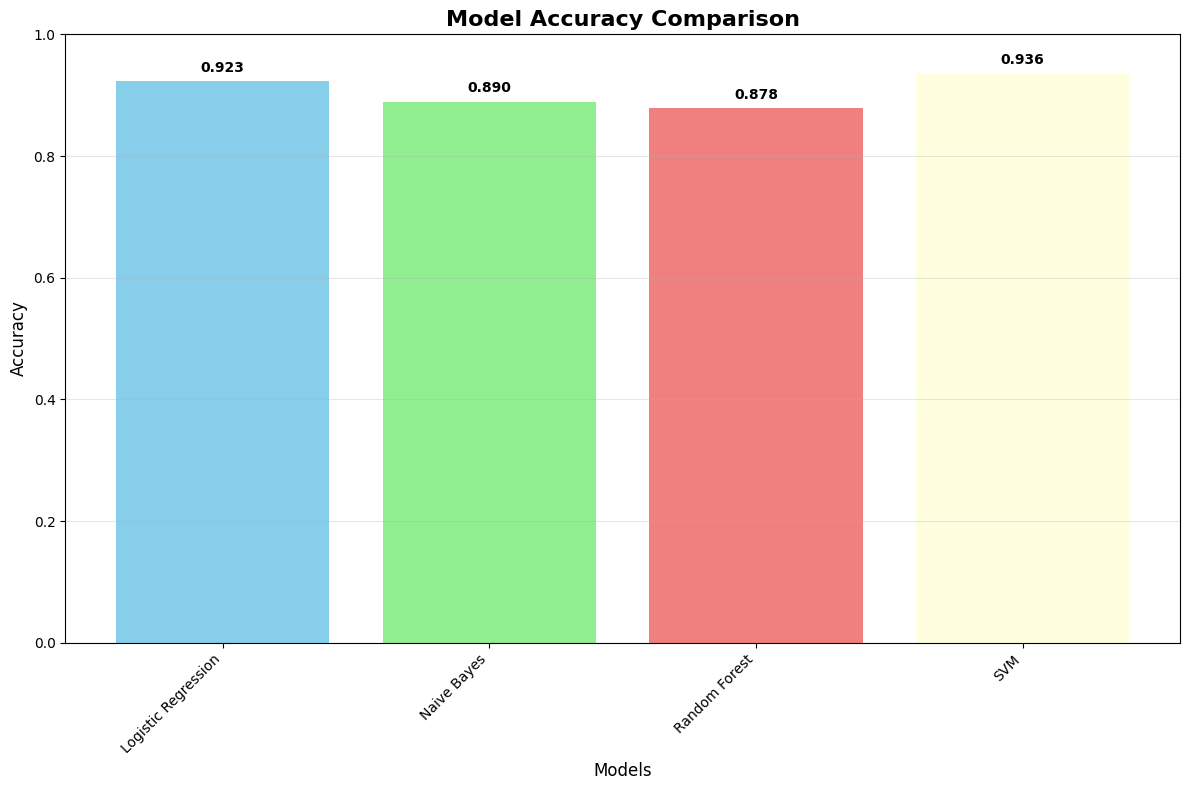


Best performing model: SVM
Best accuracy: 0.9361

MODEL PERFORMANCE SUMMARY
Model                Accuracy   AUC Score 
------------------------------------------------------------
Logistic Regression  0.9234     0.9776    
Naive Bayes          0.8895     0.9498    
Random Forest        0.8785     0.9433    
SVM                  0.9361     0.9814    

🎉 FAKE NEWS CLASSIFIER READY!
✅ Dataset loaded: 6335 articles
✅ Best model: SVM
✅ Accuracy: 93.6%
✅ Features: 5000 TF-IDF features
✅ Models trained: Logistic Regression, Naive Bayes, Random Forest, SVM

📝 How to use:
   test_your_article('Your news article text here...')

🔍 Example:
   test_your_article('Breaking: Scientists discover amazing new technology!')

🧪 Quick Test:
Article: SHOCKING: Doctors hate this one weird trick!...
Prediction: Prediction: Fake (Confidence: 0.99)
Fake probability: 0.993
Real probability: 0.007

Article: University researchers published peer-reviewed study in Nature journal....
Prediction: Prediction: Fake (C

In [ ]:
# =============================================================================
# 1. INSTALLATION AND IMPORTS
# =============================================================================


!pip install datasets transformers wordcloud seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data with error handling
def download_nltk_data():
    """Download required NLTK data with error handling."""
    required_data = ['stopwords', 'punkt', 'vader_lexicon']

    for data_name in required_data:
        try:
            nltk.download(data_name, quiet=True)
        except Exception as e:
            print(f"Warning: Could not download {data_name}: {e}")

    # Try alternative punkt download
    try:
        nltk.download('punkt_tab', quiet=True)
    except:
        pass

download_nltk_data()

# =============================================================================
# 2. ROBUST FEATURE NAME EXTRACTION FUNCTION
# =============================================================================

def get_feature_names_safe(vectorizer):
    """
    Safely extract feature names from vectorizer, handling different scikit-learn versions.
    """
    try:
        # Try new method first (sklearn >= 1.0)
        if hasattr(vectorizer, 'get_feature_names_out'):
            feature_names = vectorizer.get_feature_names_out()
            # Handle different return types
            if hasattr(feature_names, 'toarray'):
                feature_names = feature_names.toarray().flatten()
            # Ensure it's a list
            return list(feature_names)

        # Fall back to old method (sklearn < 1.0)
        elif hasattr(vectorizer, 'get_feature_names'):
            return list(vectorizer.get_feature_names())

        else:
            print("Warning: Could not extract feature names from vectorizer")
            return None

    except Exception as e:
        print(f"Error extracting feature names: {e}")
        return None

# =============================================================================
# 3. DATA LOADING AND EXPLORATION
# =============================================================================

def load_fake_news_dataset(filepath='fake_or_real_news.csv'):
    """Load the fake_or_real_news.csv dataset with robust error handling."""
    try:
        # Try different encodings
        encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        df = None

        for encoding in encodings_to_try:
            try:
                df = pd.read_csv(filepath, encoding=encoding)
                print(f"Dataset loaded successfully from {filepath} (encoding: {encoding})")
                break
            except UnicodeDecodeError:
                continue

        if df is None:
            df = pd.read_csv(filepath)  # Last attempt with default encoding

        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Display basic info about the dataset
        print("\nDataset Info:")
        print(df.info())

        # Check for missing values
        print("\nMissing values:")
        print(df.isnull().sum())

        # Display first few rows
        print("\nFirst 5 rows:")
        print(df.head())

        return df

    except FileNotFoundError:
        print(f"Error: Could not find the file '{filepath}'")
        print("Please make sure the file is in the current directory or provide the correct path.")
        print("Expected columns: ['title', 'text', 'label'] or similar")
        return None
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None

# Load the dataset
df = load_fake_news_dataset()

if df is not None:
    # Handle different column names that might exist
    column_mapping = {}

    # Check for common column name variations
    df_columns_lower = [col.lower() for col in df.columns]

    # Map title column
    if 'title' in df_columns_lower:
        column_mapping['title'] = df.columns[df_columns_lower.index('title')]
    elif 'headline' in df_columns_lower:
        column_mapping['title'] = df.columns[df_columns_lower.index('headline')]
    else:
        # Use first text column as title
        text_cols = [col for col in df.columns if df[col].dtype == 'object']
        if text_cols:
            column_mapping['title'] = text_cols[0]

    # Map text/content column
    if 'text' in df_columns_lower:
        column_mapping['text'] = df.columns[df_columns_lower.index('text')]
    elif 'content' in df_columns_lower:
        column_mapping['text'] = df.columns[df_columns_lower.index('content')]
    elif 'article' in df_columns_lower:
        column_mapping['text'] = df.columns[df_columns_lower.index('article')]
    else:
        # Use second text column as content
        text_cols = [col for col in df.columns if df[col].dtype == 'object']
        if len(text_cols) > 1:
            column_mapping['text'] = text_cols[1]

    # Map label column
    if 'label' in df_columns_lower:
        column_mapping['label'] = df.columns[df_columns_lower.index('label')]
    elif 'class' in df_columns_lower:
        column_mapping['label'] = df.columns[df_columns_lower.index('class')]
    elif 'category' in df_columns_lower:
        column_mapping['label'] = df.columns[df_columns_lower.index('category')]

    print(f"\nColumn mapping: {column_mapping}")

    # Rename columns for consistency
    if len(column_mapping) >= 2:  # At least text and label
        df_renamed = df.rename(columns={v: k for k, v in column_mapping.items()})

        # Ensure we have the minimum required columns
        if 'title' not in df_renamed.columns and 'text' in df_renamed.columns:
            df_renamed['title'] = ''  # Create empty title column
        elif 'text' not in df_renamed.columns and 'title' in df_renamed.columns:
            df_renamed['text'] = df_renamed['title']  # Use title as text

        df = df_renamed

        # Explore the label column
        print(f"\nLabel distribution:")
        print(df['label'].value_counts())

        # Check unique labels to understand the format
        print(f"\nUnique labels: {df['label'].unique()}")

        # Convert labels to binary if needed
        if df['label'].dtype == 'object':  # If labels are strings
            # Map string labels to binary
            label_mapping = {}
            unique_labels = df['label'].unique()

            # Common label formats in fake news datasets
            if any('FAKE' in str(label).upper() for label in unique_labels):
                # Handle FAKE/REAL format
                label_mapping = {}
                for label in unique_labels:
                    if 'FAKE' in str(label).upper():
                        label_mapping[label] = 1
                    else:
                        label_mapping[label] = 0
            elif any('FALSE' in str(label).upper() for label in unique_labels):
                # Handle TRUE/FALSE format
                label_mapping = {}
                for label in unique_labels:
                    if 'FALSE' in str(label).upper():
                        label_mapping[label] = 1
                    else:
                        label_mapping[label] = 0
            else:
                # Default mapping based on sorted order
                sorted_labels = sorted(unique_labels)
                label_mapping = {sorted_labels[0]: 0, sorted_labels[1]: 1}
                print(f"Auto-mapped labels: {label_mapping}")

            df['binary_label'] = df['label'].map(label_mapping)
            print(f"\nLabel mapping applied: {label_mapping}")
            print(f"Binary label distribution:")
            print(df['binary_label'].value_counts())
        else:
            # If labels are already numeric
            df['binary_label'] = df['label']

        # Combine title and text for better feature extraction
        df['title'] = df['title'].fillna('')
        df['text'] = df['text'].fillna('')
        df['combined_text'] = df['title'] + ' ' + df['text']

        # Remove rows with missing labels
        df = df.dropna(subset=['binary_label'])

        # Remove rows with empty text
        df = df[df['combined_text'].str.strip() != '']

        print(f"\nFinal dataset shape after cleaning: {df.shape}")

        # Display sample of combined text
        print("\nSample of combined text (title + content):")
        for i in range(min(3, len(df))):
            print(f"\nExample {i+1}:")
            print(f"Label: {df['label'].iloc[i]} (Binary: {df['binary_label'].iloc[i]})")
            print(f"Title: {df['title'].iloc[i][:100]}...")
            print(f"Text preview: {df['text'].iloc[i][:200]}...")
            print("-" * 80)
    else:
        print("Error: Could not identify required columns (text and label)")
        df = None

# =============================================================================
# 4. TEXT PREPROCESSING
# =============================================================================

def preprocess_text(text):
    """Clean and preprocess text data with robust error handling."""
    if pd.isna(text) or text == '':
        return ""

    try:
        # Convert to string and lowercase
        text = str(text).lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize with error handling
        try:
            tokens = word_tokenize(text)
        except Exception as e:
            # Fallback to simple split if NLTK fails
            tokens = text.split()

        # Remove stopwords with error handling
        try:
            stop_words = set(stopwords.words('english'))
        except Exception as e:
            # Fallback stopwords if NLTK fails
            stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should'])

        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

        return ' '.join(tokens)

    except Exception as e:
        print(f"Warning: Error preprocessing text: {e}")
        return str(text).lower()  # Return simple lowercase version as fallback

if df is not None:
    # Apply preprocessing
    print("Preprocessing text data...")
    df['processed_text'] = df['combined_text'].apply(preprocess_text)

    # Remove rows with empty processed text
    df = df[df['processed_text'].str.len() > 0]

    # Show example of preprocessing
    print("\nOriginal vs Processed:")
    for i in range(min(2, len(df))):
        print(f"Original: {df['combined_text'].iloc[i][:100]}...")
        print(f"Processed: {df['processed_text'].iloc[i][:100]}...")
        print("-" * 50)

# =============================================================================
# 5. EXPLORATORY DATA ANALYSIS (UPDATED WITH BOX PLOTS)
# =============================================================================

if df is not None:
    try:
        # Calculate derived features before visualization
        df['text_length'] = df['combined_text'].str.len()
        df['word_count'] = df['processed_text'].str.split().str.len()
        df['title_length'] = df['title'].str.len()

        # Calculate average word length safely
        def safe_avg_word_length(text):
            try:
                words = str(text).split()
                if words:
                    return np.mean([len(word) for word in words])
                else:
                    return 0
            except:
                return 0

        df['avg_word_length'] = df['processed_text'].apply(safe_avg_word_length)

        # Create label names for better visualization
        df['label_name'] = df['binary_label'].map({0: 'Real News', 1: 'Fake News'})

        # Visualize data with improved plots
        plt.figure(figsize=(15, 10))

        # Label distribution (bar plot)
        plt.subplot(2, 3, 1)
        label_counts = df['binary_label'].value_counts()
        labels = ['Real News' if x == 0 else 'Fake News' for x in label_counts.index]
        colors = ['lightblue', 'lightcoral']
        plt.bar(labels, label_counts.values, color=colors)
        plt.title('Distribution of Labels')
        plt.ylabel('Count')

        # Text length analysis (BOX PLOT)
        plt.subplot(2, 3, 2)
        # Prepare data for box plot
        text_length_data = [
            df[df['binary_label'] == 0]['text_length'].values,
            df[df['binary_label'] == 1]['text_length'].values
        ]
        bp1 = plt.boxplot(text_length_data, labels=['Real', 'Fake'], patch_artist=True)
        bp1['boxes'][0].set_facecolor('lightblue')
        bp1['boxes'][1].set_facecolor('lightcoral')
        plt.title('Text Length Distribution')
        plt.ylabel('Text Length (characters)')
        plt.yscale('log')  # Log scale for better visualization if there are outliers

        # Word count analysis (BOX PLOT)
        plt.subplot(2, 3, 3)
        # Prepare data for box plot
        word_count_data = [
            df[df['binary_label'] == 0]['word_count'].values,
            df[df['binary_label'] == 1]['word_count'].values
        ]
        bp2 = plt.boxplot(word_count_data, labels=['Real', 'Fake'], patch_artist=True)
        bp2['boxes'][0].set_facecolor('lightblue')
        bp2['boxes'][1].set_facecolor('lightcoral')
        plt.title('Word Count Distribution')
        plt.ylabel('Word Count')

        # Additional analysis: Average word length
        plt.subplot(2, 3, 4)
        avg_word_data = [
            df[df['binary_label'] == 0]['avg_word_length'].values,
            df[df['binary_label'] == 1]['avg_word_length'].values
        ]
        bp3 = plt.boxplot(avg_word_data, labels=['Real', 'Fake'], patch_artist=True)
        bp3['boxes'][0].set_facecolor('lightblue')
        bp3['boxes'][1].set_facecolor('lightcoral')
        plt.title('Average Word Length Distribution')
        plt.ylabel('Average Word Length')

        # Title length analysis
        plt.subplot(2, 3, 5)
        title_length_data = [
            df[df['binary_label'] == 0]['title_length'].values,
            df[df['binary_label'] == 1]['title_length'].values
        ]
        bp4 = plt.boxplot(title_length_data, labels=['Real', 'Fake'], patch_artist=True)
        bp4['boxes'][0].set_facecolor('lightblue')
        bp4['boxes'][1].set_facecolor('lightcoral')
        plt.title('Title Length Distribution')
        plt.ylabel('Title Length (characters)')

        # Correlation heatmap
        plt.subplot(2, 3, 6)
        corr_data = df[['text_length', 'word_count', 'title_length', 'avg_word_length', 'binary_label']].corr()
        sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Feature Correlation Matrix')

        plt.tight_layout()
        plt.show()

        # Statistical summary
        print("\nDataset Statistics:")
        print(f"Total articles: {len(df)}")
        print(f"Fake news articles: {len(df[df['binary_label'] == 1])}")
        print(f"Real news articles: {len(df[df['binary_label'] == 0])}")
        print(f"Average text length: {df['text_length'].mean():.0f} characters")
        print(f"Average word count: {df['word_count'].mean():.0f} words")

        # Statistical comparison between real and fake news
        print("\n" + "="*50)
        print("STATISTICAL COMPARISON: REAL vs FAKE NEWS")
        print("="*50)

        real_stats = df[df['binary_label'] == 0][['text_length', 'word_count', 'title_length', 'avg_word_length']].describe()
        fake_stats = df[df['binary_label'] == 1][['text_length', 'word_count', 'title_length', 'avg_word_length']].describe()

        print("\nReal News Statistics:")
        print(real_stats)
        print("\nFake News Statistics:")
        print(fake_stats)

    except Exception as e:
        print(f"Warning: Error in data analysis: {e}")
        print("Continuing with model training...")

# =============================================================================
# 6. FEATURE ENGINEERING
# =============================================================================

if df is not None:
    # Split the data
    X = df['processed_text']
    y = df['binary_label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Training label distribution:")
    print(y_train.value_counts())

    # TF-IDF Vectorization with error handling
    print("\nCreating TF-IDF features...")
    try:
        tfidf = TfidfVectorizer(
            max_features=5000,  # Reduced to avoid memory issues
            ngram_range=(1, 2),  # unigrams and bigrams
            min_df=2,
            max_df=0.95,
            stop_words='english'
        )

        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)

        print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")

        # Show most important features using our safe function
        feature_names = get_feature_names_safe(tfidf)
        if feature_names:
            print(f"Total features: {len(feature_names)}")
            print(f"Sample features: {feature_names[:10]}")
        else:
            print("Could not extract feature names, but vectorization successful")

    except Exception as e:
        print(f"Error in TF-IDF vectorization: {e}")
        print("Trying with simpler parameters...")

        # Fallback with simpler parameters
        tfidf = TfidfVectorizer(
            max_features=1000,
            ngram_range=(1, 1),  # Only unigrams
            min_df=5,
            max_df=0.9
        )

        X_train_tfidf = tfidf.fit_transform(X_train)
        X_test_tfidf = tfidf.transform(X_test)
        print(f"Fallback TF-IDF matrix shape: {X_train_tfidf.shape}")

# =============================================================================
# 7. MODEL TRAINING AND EVALUATION
# =============================================================================

if df is not None:
    # Dictionary to store results
    results = {}

    def evaluate_model(name, model, X_train, X_test, y_train, y_test):
        """Train and evaluate a model with error handling."""
        print(f"\n=== {name} ===")

        try:
            # Train model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = None

            # Get probabilities if available
            try:
                if hasattr(model, "predict_proba"):
                    y_pred_proba = model.predict_proba(X_test)[:, 1]
                elif hasattr(model, "decision_function"):
                    y_pred_proba = model.decision_function(X_test)
            except:
                pass

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)

            if y_pred_proba is not None:
                try:
                    auc_score = roc_auc_score(y_test, y_pred_proba)
                    print(f"Accuracy: {accuracy:.4f}")
                    print(f"AUC Score: {auc_score:.4f}")
                    results[name] = {'accuracy': accuracy, 'auc': auc_score, 'model': model}
                except:
                    print(f"Accuracy: {accuracy:.4f}")
                    results[name] = {'accuracy': accuracy, 'auc': None, 'model': model}
            else:
                print(f"Accuracy: {accuracy:.4f}")
                results[name] = {'accuracy': accuracy, 'auc': None, 'model': model}

            # Print classification report
            print("\nClassification Report:")
            try:
                print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
            except:
                print("Accuracy:", accuracy)

            return model, y_pred

        except Exception as e:
            print(f"Error training {name}: {e}")
            return None, None

    # Train multiple models with simpler parameters to avoid errors
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10),  # Smaller to avoid memory issues
    }

    # Only add SVM if dataset is not too large (to avoid memory issues)
    if len(X_train) < 10000:
        models['SVM'] = SVC(probability=True, random_state=42, kernel='linear', C=1.0)

    for name, model in models.items():
        evaluate_model(name, model, X_train_tfidf, X_test_tfidf, y_train, y_test)

# =============================================================================
# 8. MODEL COMPARISON AND BEST MODEL SELECTION (FIXED BAR GRAPH)
# =============================================================================

if df is not None and results:
    try:
        # Compare model performance - FIXED to handle dynamic model list
        model_names = list(results.keys())
        accuracies = [results[name]['accuracy'] for name in model_names]

        # Define colors for each possible model (handle dynamic model list)
        color_map = {
            'Logistic Regression': 'skyblue',
            'Naive Bayes': 'lightgreen',
            'Random Forest': 'lightcoral',
            'SVM': 'lightyellow'
        }

        # Get colors for actual models in results
        colors = [color_map.get(name, 'lightgray') for name in model_names]

        plt.figure(figsize=(12, 8))
        bars = plt.bar(model_names, accuracies, color=colors)
        plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=12)
        plt.xlabel('Models', fontsize=12)
        plt.ylim(0, 1)

        # Add accuracy values on top of bars
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                     f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        # Rotate x-axis labels if needed
        if len(model_names) > 3:
            plt.xticks(rotation=45, ha='right')

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Find best model
        best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
        best_model = results[best_model_name]['model']

        print(f"\nBest performing model: {best_model_name}")
        print(f"Best accuracy: {results[best_model_name]['accuracy']:.4f}")

        # Display all model results in a table format
        print("\n" + "="*60)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*60)
        print(f"{'Model':<20} {'Accuracy':<10} {'AUC Score':<10}")
        print("-"*60)
        for name in model_names:
            auc_str = f"{results[name]['auc']:.4f}" if results[name]['auc'] is not None else "N/A"
            print(f"{name:<20} {results[name]['accuracy']:<10.4f} {auc_str:<10}")

    except Exception as e:
        print(f"Error in model comparison: {e}")
        # Use first available model as best
        if results:
            best_model_name = list(results.keys())[0]
            best_model = results[best_model_name]['model']
            print(f"Using {best_model_name} as the primary model")

# =============================================================================
# 9. PREDICTION FUNCTION
# =============================================================================

def predict_news_credibility(text, model=None, vectorizer=None):
    """Predict if a news article is fake or real with robust error handling."""
    if model is None or vectorizer is None:
        if 'best_model' not in globals() or 'tfidf' not in globals():
            return {"error": "Model not trained yet. Please run the training section first."}
        model = best_model
        vectorizer = tfidf

    try:
        # Preprocess the text
        processed_text = preprocess_text(text)

        if not processed_text or processed_text.strip() == "":
            return {"error": "No valid text to analyze after preprocessing."}

        # Vectorize
        text_vector = vectorizer.transform([processed_text])

        # Make prediction
        prediction = model.predict(text_vector)[0]

        result = "Fake" if prediction == 1 else "Real"

        # Get confidence if possible
        try:
            if hasattr(model, 'predict_proba'):
                confidence = model.predict_proba(text_vector)[0]
                confidence_score = max(confidence)
                fake_prob = confidence[1]
                real_prob = confidence[0]

                return {
                    'prediction': result,
                    'confidence': confidence_score,
                    'fake_probability': fake_prob,
                    'real_probability': real_prob,
                    'summary': f"Prediction: {result} (Confidence: {confidence_score:.2f})"
                }
            else:
                return {
                    'prediction': result,
                    'summary': f"Prediction: {result}"
                }
        except:
            return {
                'prediction': result,
                'summary': f"Prediction: {result}"
            }

    except Exception as e:
        return {"error": f"Error making prediction: {str(e)}"}

# =============================================================================
# 10. TESTING FUNCTION
# =============================================================================

def test_your_article(text):
    """Easy function to test any article."""
    if not text or text.strip() == "":
        print("Please provide some text to analyze.")
        return None

    result = predict_news_credibility(text)

    if "error" in result:
        print(f"Error: {result['error']}")
        return None

    print(f"Article: {text[:100]}...")
    print(f"Prediction: {result['summary']}")

    if 'fake_probability' in result and result['fake_probability'] is not None:
        print(f"Fake probability: {result['fake_probability']:.3f}")
        print(f"Real probability: {result['real_probability']:.3f}")

    return result

# =============================================================================
# 11. FINAL STATUS
# =============================================================================

if df is not None and results:
    print("\n" + "="*50)
    print("🎉 FAKE NEWS CLASSIFIER READY!")
    print("="*50)
    print(f"✅ Dataset loaded: {len(df)} articles")
    print(f"✅ Best model: {best_model_name}")
    print(f"✅ Accuracy: {results[best_model_name]['accuracy']:.1%}")
    print(f"✅ Features: {X_train_tfidf.shape[1]} TF-IDF features")
    print(f"✅ Models trained: {', '.join(results.keys())}")
    print("\n📝 How to use:")
    print("   test_your_article('Your news article text here...')")
    print("\n🔍 Example:")
    print("   test_your_article('Breaking: Scientists discover amazing new technology!')")

    # Quick test
    print("\n🧪 Quick Test:")
    test_articles = [
        "SHOCKING: Doctors hate this one weird trick!",
        "University researchers published peer-reviewed study in Nature journal."
    ]

    for article in test_articles:
        test_your_article(article)
        print()

else:
    print("\n❌ Setup failed. Please check:")
    print("1. Make sure 'fake_or_real_news.csv' is in your directory")
    print("2. The CSV should have text and label columns")
    print("3. Check for any error messages above")